In [1]:
from pathlib import Path
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

from ebm.probability import log_distributions, fit_distributions, predict_stage
from ebm.mcmc import greedy_ascent, mcmc, get_optimal_order

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
folder = Path('/data01/bgutman/MRI_data/PPMI/EBM_data/')
data = pd.read_csv(folder / 'corrected_ENIGMA-PD_Mixed_Effects_train_test_split.csv', index_col=0)

train, test = train_test_split(data, stratify=data['cohort'], test_size=0.1, random_state=777)
X_train = train.drop(['SubjID', 'Dx', 'Sex', 'Age', 'cohort'], axis=1).values
y_train = train['Dx'].values
X_test = test.drop(['SubjID', 'Dx', 'Sex', 'Age', 'cohort'], axis=1).values
y_test = test['Dx'].values

df = pd.read_csv(folder / 'ENIGMA-PD-regional.csv')

train_log_p_e, train_log_p_not_e = log_distributions(X_train, y_train)
test_log_p_e, test_log_p_not_e = log_distributions(X_train, y_train, X_test=X_test, y_test=y_test)

In [90]:
all_orders = np.load('../logs/order_mcmc.npy')
# all_orders_prior = np.load('../logs/prior_order_mcmc.npy')
order_map, best_order = get_optimal_order(all_orders)

In [14]:
best_order

array([43,  9,  6, 40, 61, 27, 23, 57, 29, 15, 22, 56, 36,  2, 60, 26, 25,
       20, 54, 63, 18, 16, 62, 28, 34, 13, 47, 41,  7, 59, 51, 52, 50, 44,
        0, 11, 32, 53,  3, 37, 45, 67, 49, 39, 66, 64, 17, 46, 12, 10, 30,
       33, 21, 55, 24, 42, 58,  8, 35,  4, 38, 31, 65, 48, 14,  1, 19,  5])

In [91]:
# print(train.drop(['SubjID', 	'Dx', 	'Sex', 	'Age', 	'cohort'], axis=1).columns[best_order])

In [92]:
# plt.imshow(order_map[best_order]);

In [98]:
probas = predict_stage(best_order, test_log_p_e, test_log_p_not_e).T
stage = np.argmax(probas, axis=1)
test['pred_stage'] = stage

/home/kurmukov/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [99]:
sub = pd.merge(left=df[['SubjID', 'site', 'cohort', 'HY1234']], right=test, on='SubjID', how='right')

In [101]:
sub[['HY1234', 'pred_stage']]

,HY1234,pred_stage
0,0.0,18
1,0.0,48
2,0.0,56
3,NaN,53
4,NaN,65
5,NaN,39
6,3.0,60
7,0.0,60
8,0.0,37
9,3.0,37


In [83]:
def compute_expectation(log_probabilities):
    expected = 0
    for s, p in zip(np.arange(68), np.exp(log_probabilities)):
        expected+= s*p
    return expected/np.exp(log_probabilities).sum()

def compute_all_expectations(all_log_probabilities):
    expected = []
    for subject in all_log_probabilities:
        expected.append(compute_expectation(subject))
    return expected

In [84]:
stages_expected = compute_all_expectations(probas)

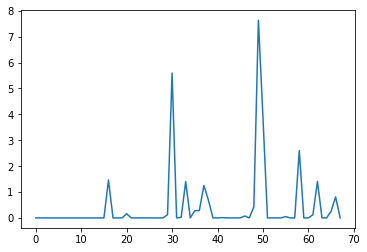

In [65]:
plt.plot(np.exp(probas[2]))

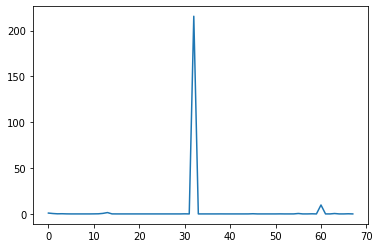

In [36]:
plt.plot(np.exp(probas[5]))

In [48]:
sub.groupby('Dx')['pred_stage'].agg(['mean','std', 'count'])

,mean,std,count
Dx,,,
0,38.314286,19.676030,70
1,41.088710,18.383897,124


# TODO: compute stats. signific. t-test

In [51]:
19/np.sqrt(70)

2.270934357735348

In [50]:
19/np.sqrt(124)

1.7062503692543616

In [40]:
sub.groupby('HY1234')['pred_stage'].agg(['mean', 'count'])

,mean,count
HY1234,,
0.0,38.333333,69
1.0,44.166667,24
2.0,40.540984,61
3.0,53.666667,9
4.0,36.750000,4


In [85]:
# probas = predict_stage(best_order,train_log_p_e, train_log_p_not_e).T
# stage = np.argmax(probas, axis=1)
# train['pred_stage'] = stage

train['pred_expected_stage'] = stages_expected

/home/kurmukov/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [86]:
sub = pd.merge(left=df[['SubjID', 'site', 'cohort', 'HY1234']], right=train, on='SubjID', how='right')

In [88]:
sub.groupby(['Dx'])['pred_expected_stage'].agg(['mean', 'std', 'count'])

,mean,std,count
Dx,,,
0,37.776240,11.458195,684
1,37.984613,12.510678,1058


In [89]:
sub.groupby(['HY1234'])['pred_expected_stage'].agg(['median','mean', 'std', 'count'])

,median,mean,std,count
HY1234,,,,
0.0,38.002160,37.650079,11.393459,667
1.0,35.014881,35.996982,12.830884,209
2.0,38.986690,38.561120,12.605632,510
3.0,36.780485,37.765888,13.045555,120
4.0,35.299150,36.598547,12.485571,32
